In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import pickle
from gensim.models import Word2Vec
from gensim.models import doc2vec
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier

In [2]:
def count(text):
    return len(text.split())
def delta_score(i, k):
    return abs(i - k)
def average_word_length(sentence):
    words = sentence.split()
    return sum(len(word) for word in words) / len(words)
def feature_minus(f1, f2):
    return f1 - f2
def feature_multiply(f1, f2):
    return f1 * f2
def feature_divide(f1, f2):
    if f2==0:
        return f1
    else:
        return f1 / f2
def feature_plus(f1, f2):
    return f1 + f2

In [3]:
swords = stopwords.words('russian')

In [4]:
stem = SnowballStemmer('russian')

In [5]:
df = pd.read_csv('../data/wb_school_task_2.csv.gzip', compression='gzip')

In [6]:
df

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


In [21]:
data_structure = df.drop(index = range(1,3123))

In [30]:
data_structure.to_csv('data_structure.csv')

In [7]:
a= ['f1', 'f2', 'f3']

In [8]:
b=df[a]

In [9]:
b

,f1,f2,f3
0,1,1,1.000000
1,10,6,2.700000
2,4,4,4.000000
3,6,6,5.000000
4,19,18,5.000000
...,...,...,...
3118,2,2,3.000000
3119,8,8,4.375000
3120,13,12,5.000000
3121,3,3,5.000000


In [10]:
df['w_count'] = df.text.apply(count)
df['d_score'] = df.apply(lambda x: delta_score(x['f3'], x['f6']), axis=1)
df['av_w_len'] = df.text.apply(average_word_length)
for i in range(1, 9):
    for k in range(1, 9):
        if i == k:
            pass
        else:
            df['fmin{}'.format(str(i)+str(k))]=df.apply(lambda x: feature_minus(x['f{}'.format(int(i))], x['f{}'.format(int(k))]), axis=1)
            df['fplus{}'.format(str(i)+str(k))]=df.apply(lambda x: feature_plus(x['f{}'.format(int(i))], x['f{}'.format(int(k))]), axis=1)
            df['fmult{}'.format(str(i)+str(k))]=df.apply(lambda x: feature_multiply(x['f{}'.format(int(i))], x['f{}'.format(int(k))]), axis=1)
            df['fdiv{}'.format(str(i)+str(k))]=df.apply(lambda x: feature_divide(x['f{}'.format(int(i))], x['f{}'.format(int(k))]), axis=1)

In [11]:
df['rand_f'] = np.random.rand(df.shape[0])

In [12]:
text = df.text

In [10]:
text[0]

'Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.'

# Первичная обработка

In [11]:
tokenized_sw_p = pd.Series([nltk.word_tokenize(text[i], language='russian') for i in range(0, len(text))])

In [12]:
tokenized_sw_p.head()

0    [Хотела, купить, на, замену, старых, ,, по, ит...
1    [Запах, по, сравнению, с, обычным, DOVE, никак...
2            [Кабель, подошёл, ,, хорошо, работает, .]
3    [Восторг, !, Очень, приятный, аромат, ,, держи...
4    [Визуально, все, хорошо, ., Не, пробовали, ., ...
dtype: object

In [13]:
stemmed = []
for i in range(0, len(tokenized_sw_p)):
    stemmed.append([stem.stem(token) for token in tokenized_sw_p[i] if token not in swords and token not in punctuation])
stemmed = pd.Series(stemmed)

In [14]:
del tokenized_sw_p
del text

In [15]:
for i in range(0, len(stemmed)):
    stemmed[i] = " ".join(stemmed[i])

In [16]:
stemmed_tok = pd.Series([nltk.word_tokenize(stemmed[i], language='russian') for i in range(0, len(stemmed))])

In [17]:
df.label[1]

1

In [18]:
stemmed_tag=[]
for i in range(0, len(stemmed_tok)):
    stemmed_tag.append(doc2vec.TaggedDocument(stemmed_tok[i], [i]))

In [19]:
wvec = Word2Vec(vector_size=100, min_count=1, workers = -1)

In [20]:
wvec.build_vocab(stemmed_tok)

In [21]:
wvec.train(stemmed_tok, total_examples=wvec.corpus_count, epochs=30)

(0, 0)

In [22]:
docvec = doc2vec.Doc2Vec(vector_size=100, min_count=1, workers = -1)

In [23]:
docvec.build_vocab(stemmed_tag)

In [24]:
docvec.train(stemmed_tag, total_examples=docvec.corpus_count, epochs=30)

In [25]:
av=[]
for i in range(0, len(stemmed_tok)):
    l = np.array([wvec.wv[tok] for tok in stemmed_tok[i]])
    av.append((np.average(a=l,  axis = 1, weights=docvec[i])))
av = pd.Series(av) 

In [26]:
av

0       [0.006501248, -0.036276843, -0.007388494, -0.0...
1       [-0.0074324375, -0.00013321558, 0.0023792938, ...
2                 [-0.39994472, -0.10498576, -0.05326255]
3       [0.008655487, -0.005591501, -0.0022221394, 0.0...
4       [0.026074508, 0.00541414, -0.034570817, 0.0017...
                              ...                        
3118    [0.0014307552, -0.0033318643, -0.0070807342, -...
3119    [0.010798217, -0.022032978, 0.026537852, 0.014...
3120    [0.01548819, -0.0035458382, -0.004728016, 0.00...
3121    [0.010622692, 0.2379645, 0.075829595, 0.073439...
3122    [-0.05496994, 0.06809626, 0.09177352, -0.06670...
Length: 3123, dtype: object

In [27]:
X = [[]]*len(stemmed_tok)
for i in range(0, len(stemmed_tok)):
    X[i]= np.append(X[i], av[i].min())
    X[i]= np.append(X[i], av[i].max())

In [28]:
X[0]

array([-0.03627684,  0.02866629])

In [29]:
del av

In [17]:
y = df.label

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

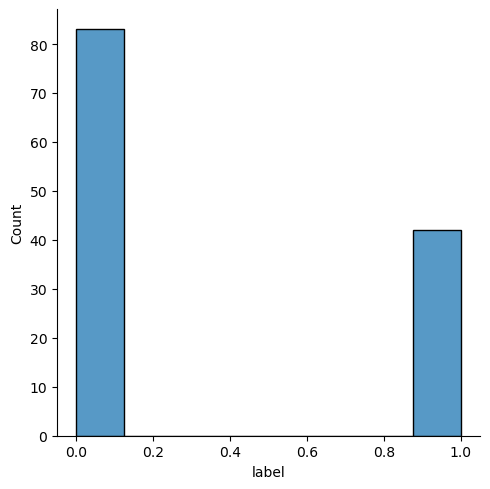

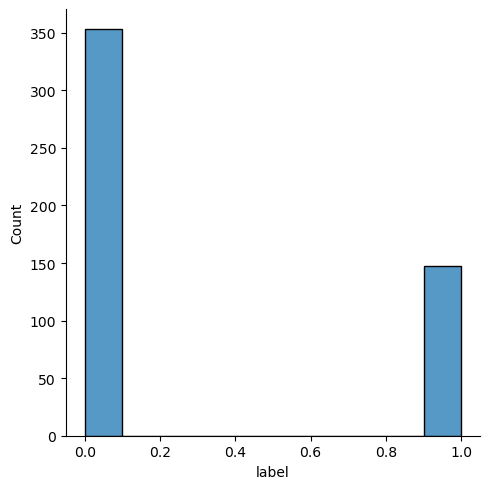

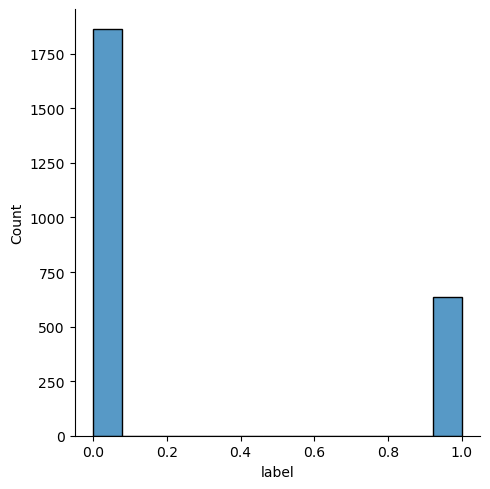

In [32]:
sns.displot(y_val)
sns.displot(y_test)
sns.displot(y_train)

In [33]:
clf = LogisticRegression()

In [34]:
clf.fit(X_train, y_train)

LogisticRegression()

In [35]:
y_pred = clf.predict(X_test)

In [36]:
cf_mx = confusion_matrix(y_test, y_pred)

<Axes: >

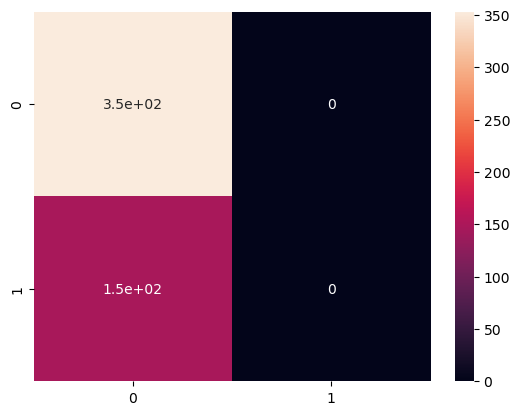

In [37]:
sns.heatmap(pd.DataFrame(cf_mx), annot=True)

In [38]:
X=[]
for i in range(0, len(stemmed_tok)):
    X.append(docvec[i])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [40]:
clf_d = LogisticRegression()

In [41]:
clf_d.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_pred = clf_d.predict(X_test)

In [43]:
cf_mx_d = confusion_matrix(y_test, y_pred)

<Axes: >

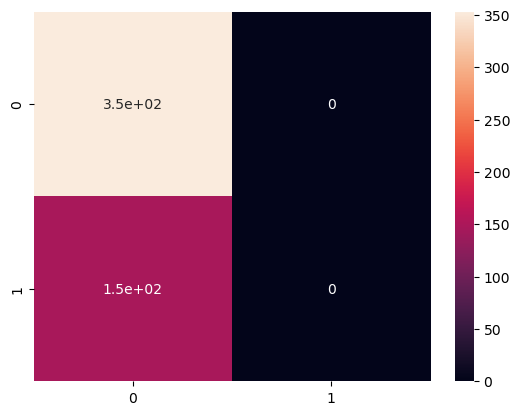

In [44]:
sns.heatmap(pd.DataFrame(cf_mx_d), annot=True)

In [16]:
X=df.drop(['id1', 'id2', 'id3', 'text', 'label'], axis=1)

In [46]:
X.shape

(3123, 236)

In [47]:
X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,w_count,d_score,...,fdiv85,fmin86,fplus86,fmult86,fdiv86,fmin87,fplus87,fmult87,fdiv87,rand_f
0,1,1,1.0,11,13,4.272727,18,36,15,3.272727,...,2.769231,31.727273,40.272727,153.818182,8.425532,18,54,648,2.000000,0.920896
1,10,6,2.7,46,4,4.434783,90,109,15,1.734783,...,27.250000,104.565217,113.434783,483.391304,24.578431,19,199,9810,1.211111,0.902691
2,4,4,4.0,14,0,4.500000,4,6,4,0.500000,...,6.000000,1.500000,10.500000,27.000000,1.333333,2,10,24,1.500000,0.081885
3,6,6,5.0,374,30,4.772727,14,15,11,0.227273,...,0.500000,10.227273,19.772727,71.590909,3.142857,1,29,210,1.071429,0.602139
4,19,18,5.0,6,4,5.000000,26,33,8,0.000000,...,8.250000,28.000000,38.000000,165.000000,6.600000,7,59,858,1.269231,0.580878


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [22]:
clf_s = pickle.load(open('../LogReg1.sav', 'rb'))

In [23]:
clf_s

LogisticRegression(C=3792.690190732246, penalty='l1', solver='liblinear')

In [24]:
y_pred = clf_s.predict(X_test)

y_pred = clf_s.predict(X_test)

In [25]:
cf_mx_s = confusion_matrix(y_test, y_pred)

In [26]:
precision_score(y_test, y_pred)

0.7384615384615385

In [27]:
recall_score(y_test, y_pred)

0.32653061224489793

In [28]:
f1_score(y_test, y_pred)

0.4528301886792453

<Axes: >

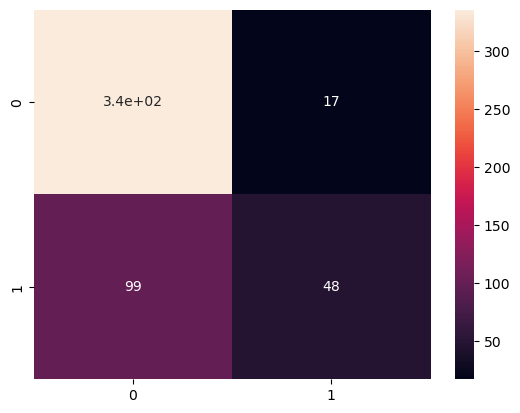

In [29]:
sns.heatmap(pd.DataFrame(cf_mx_s), annot=True)

In [57]:
cbcl = pickle.load(open('CatBoost.sav', 'rb'))

In [58]:
y_pred = cbcl.predict(X_test)

In [59]:
precision_score(y_test, y_pred)

0.7058823529411765

In [60]:
recall_score(y_test, y_pred)

0.32653061224489793

In [61]:
f1_score(y_test, y_pred)

0.4465116279069767

In [62]:
cf_mx_cb = confusion_matrix(y_test, y_pred)

<Axes: >

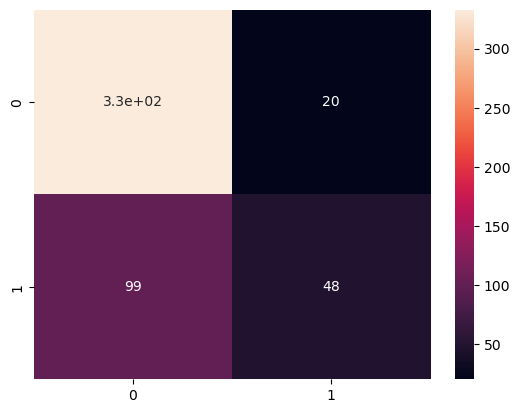

In [63]:
sns.heatmap(pd.DataFrame(cf_mx_cb), annot=True)

In [30]:
feat_imp_lr = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(clf_s.coef_[0])})

In [31]:
feat_imp_lr.sort_values(by='Importance', inplace=True, ascending=False)

In [32]:
feat_imp_lr.reset_index(inplace=True)

In [33]:
feat_imp_lr

,index,Feature,Importance
0,42,fdiv21,3.368967e+00
1,18,fdiv13,1.257645e+00
2,46,fdiv23,1.139679e+00
3,38,fdiv18,1.097270e+00
4,86,fdiv36,1.067796e+00
...,...,...,...
231,21,fmult14,1.011965e-06
232,97,fmult41,8.017346e-07
233,233,fmult87,2.365257e-07
234,137,fmult54,2.107861e-08


In [34]:
feat_imp_lr.loc[feat_imp_lr['Feature'] == 'rand_f']

,index,Feature,Importance
57,235,rand_f,0.036597


<Axes: xlabel='Importance', ylabel='Feature'>

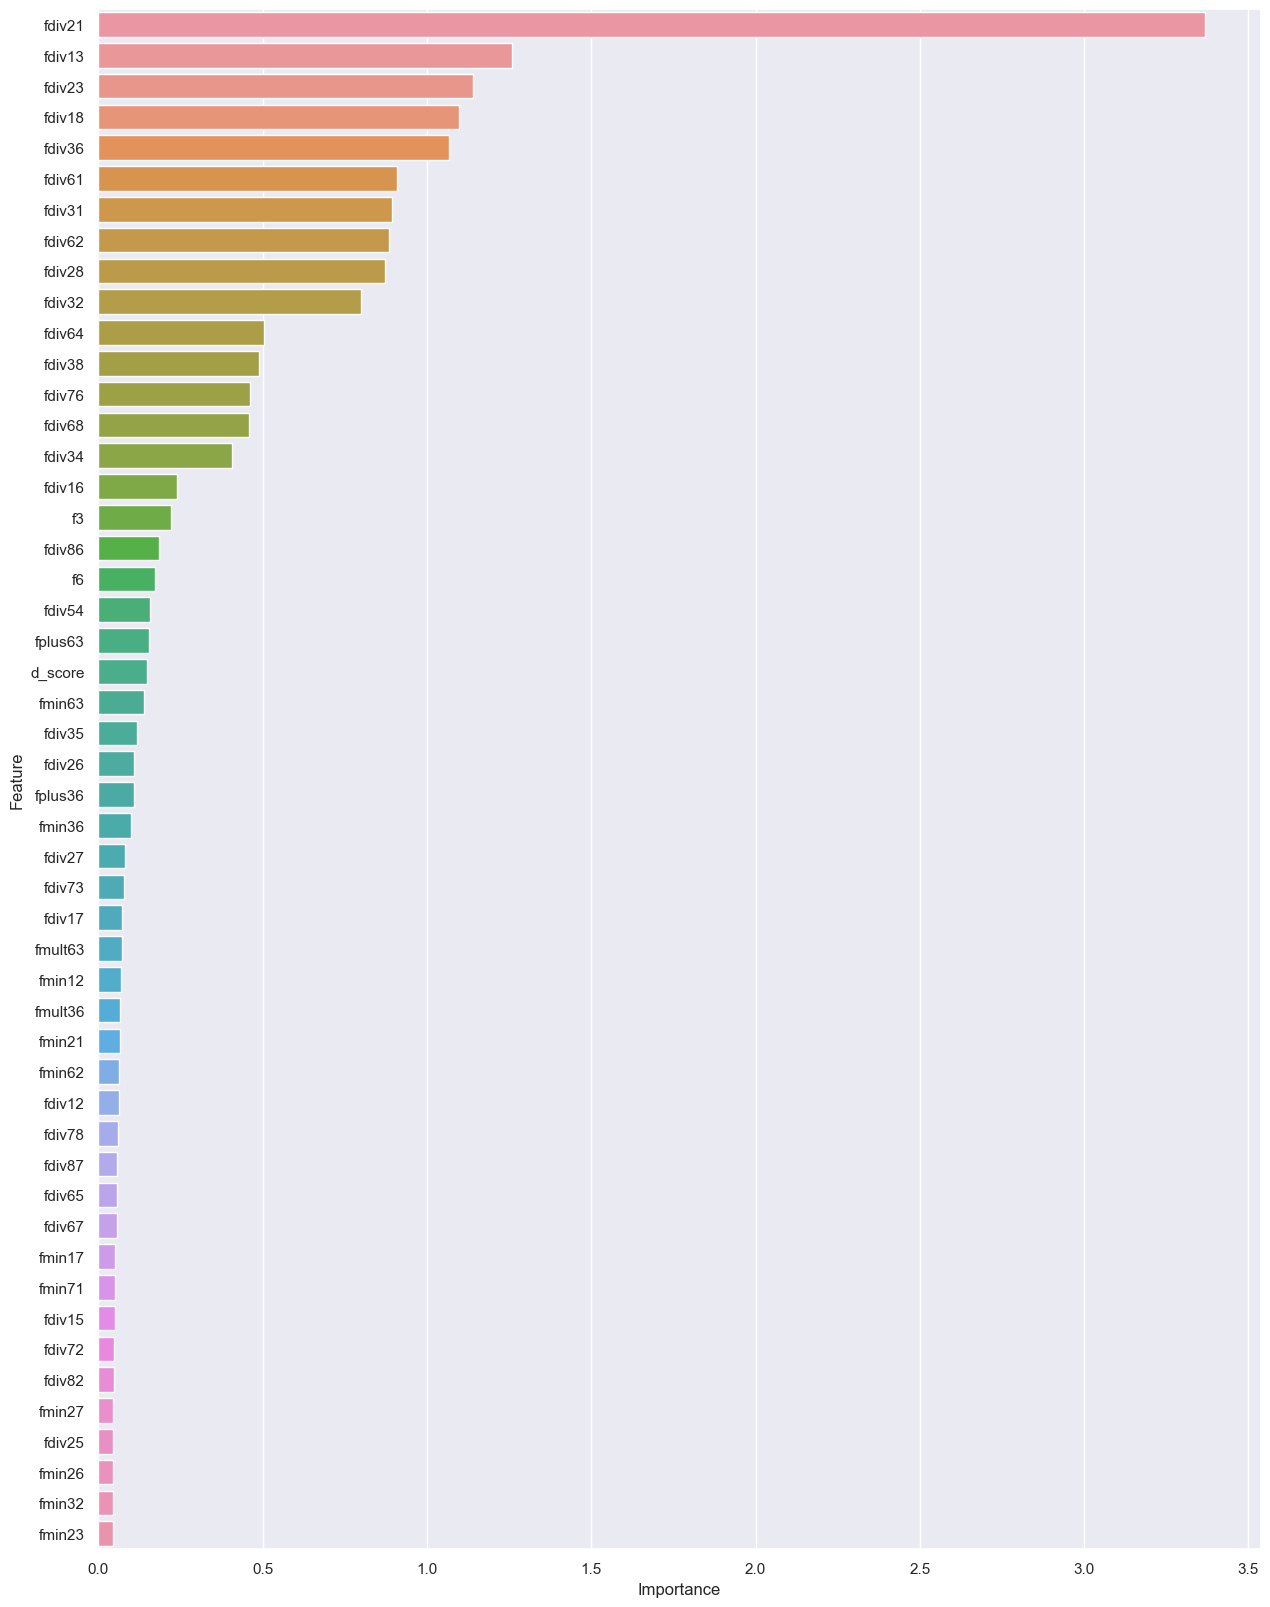

In [35]:
sns.set(rc={"figure.figsize":(15, 20)})
sns.barplot(y=feat_imp_lr.head(50).Feature, x=feat_imp_lr.head(50).Importance)

In [36]:
a=[i for i in range(0, feat_imp_lr.loc[feat_imp_lr['Feature'] == 'rand_f'].index[0])]
b=[i for i in range(feat_imp_lr.loc[feat_imp_lr['Feature'] == 'rand_f'].index[0], 236)]

In [37]:
not_imp_feat_lr = feat_imp_lr.drop(index = a)

In [38]:
feat_imp_lr

,index,Feature,Importance
0,42,fdiv21,3.368967e+00
1,18,fdiv13,1.257645e+00
2,46,fdiv23,1.139679e+00
3,38,fdiv18,1.097270e+00
4,86,fdiv36,1.067796e+00
...,...,...,...
231,21,fmult14,1.011965e-06
232,97,fmult41,8.017346e-07
233,233,fmult87,2.365257e-07
234,137,fmult54,2.107861e-08


In [39]:
imp_feat_lr = pd.Series(data= feat_imp_lr.drop(index = b).Feature)

In [40]:
feat_imp_cb = pd.DataFrame({'Feature': X.columns, 'Importance': cbcl.get_feature_importance()})

NameError: name 'cbcl' is not defined

In [41]:
feat_imp_cb.sort_values(by='Importance', inplace=True, ascending=False)

NameError: name 'feat_imp_cb' is not defined

In [42]:
feat_imp_cb.reset_index(inplace=True)

NameError: name 'feat_imp_cb' is not defined

<Axes: xlabel='Importance', ylabel='Feature'>

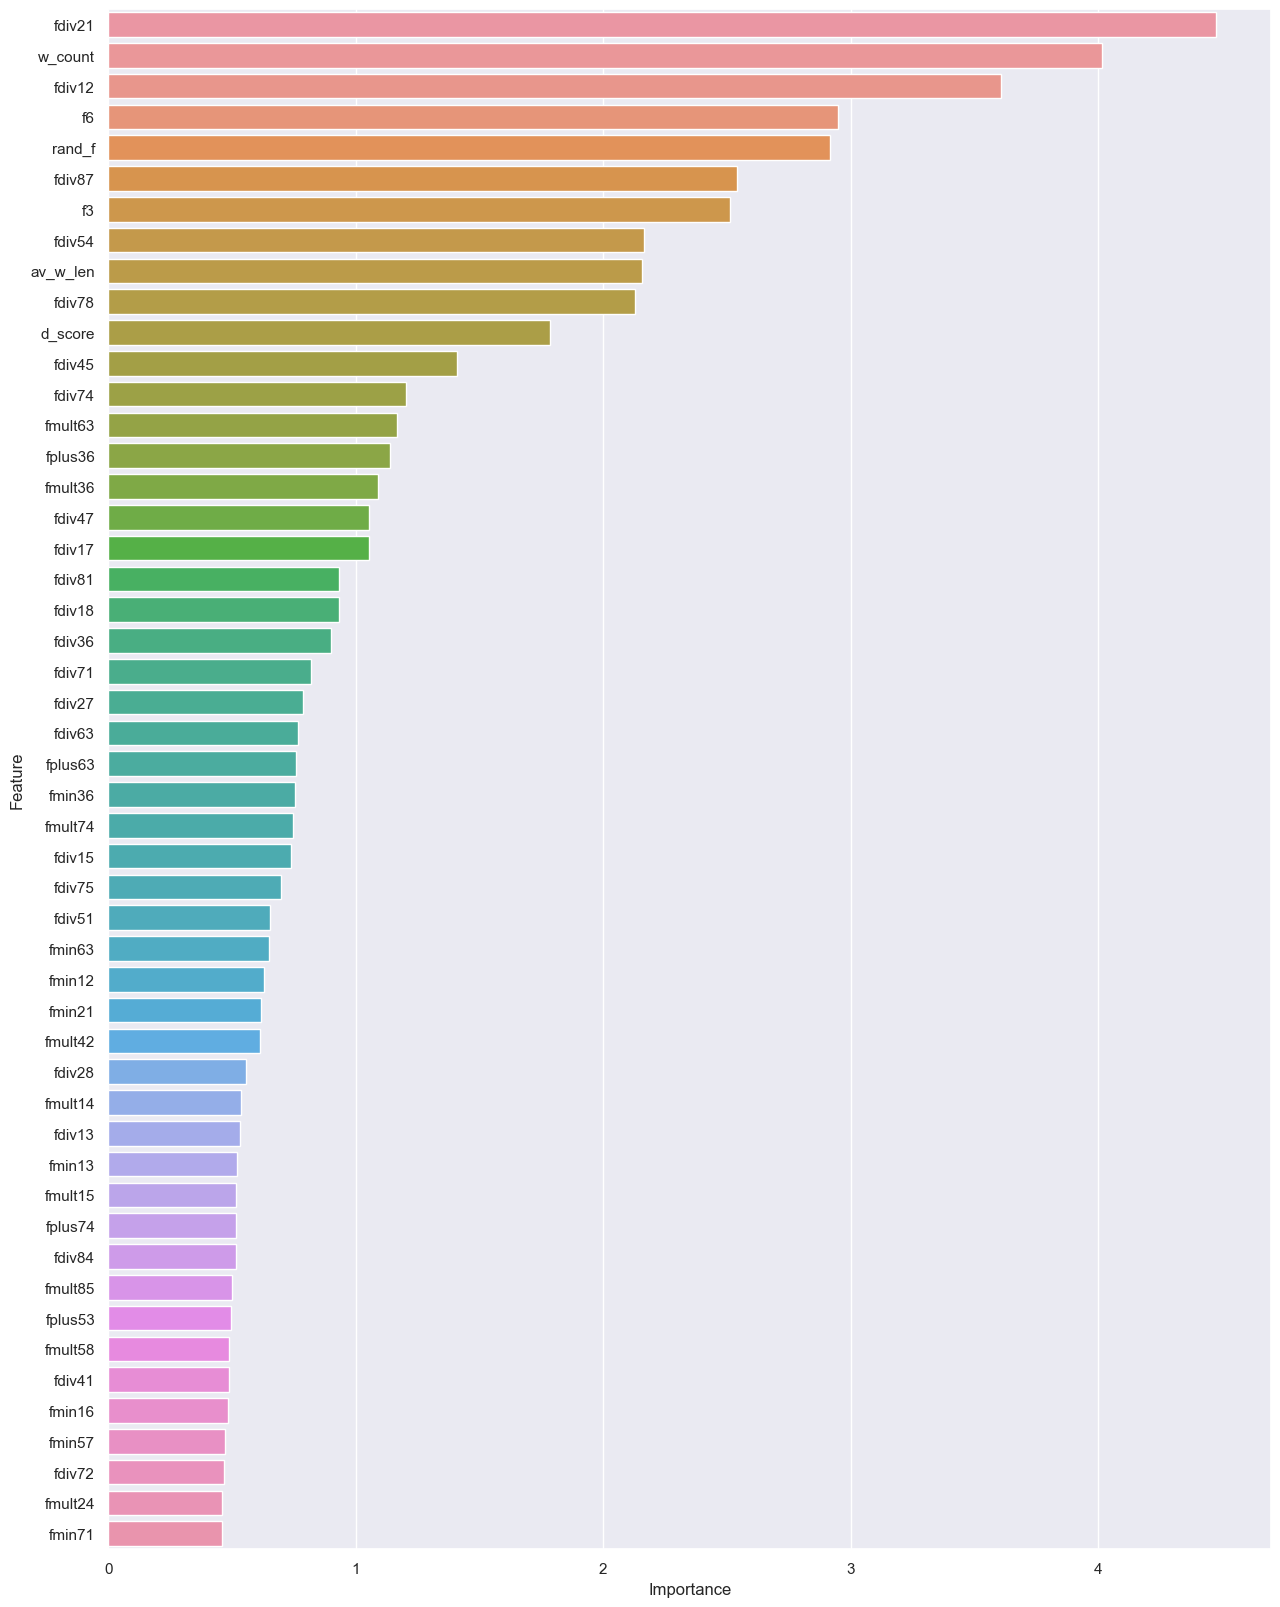

In [77]:
sns.barplot(y=feat_imp_cb.head(50).Feature, x=feat_imp_cb.head(50).Importance)

In [43]:
def feature_select(X_t, y_t, X_p, y_p, feat_list, num_feat=1, ignored_feat=[], estimator=LogisticRegression(max_iter=5000)):
    if ignored_feat:
        for feat in ignored_feat:
            feat_list.drop(feat_list.loc[feat_list == feat].index, inplace=True)
    X_train = X_t[feat_list[0:num_feat]]
    y_train = y_t
    X_test = X_p[feat_list[0:num_feat]]
    y_test = y_p
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_p)
    return {'feat list': feat_list[0:num_feat], 'precision': precision_score(y_p, y_pred), 'f1': f1_score(y_p, y_pred)}

In [44]:
X_t = X_train.drop(columns = [i for i in not_imp_feat_lr['Feature']])[imp_feat_lr]
X_p = X_test.drop(columns = [i for i in not_imp_feat_lr['Feature']])[imp_feat_lr]

In [45]:
ignored_feat = []
last_precision = 0
last_f1=0
last_list = []
tol = 0.005
num_feat=1
for i in range(1, len(imp_feat_lr)):
    feat_list=imp_feat_lr.copy()
    out = feature_select(X_t=X_t, y_t=y_train, X_p=X_p, y_p=y_test, num_feat=num_feat, ignored_feat=ignored_feat, 
                         feat_list=feat_list, estimator = CatBoostClassifier(verbose=False, random_state=42))
    print('Features: ', out['feat list'].to_list(), '\nPrecision:', out['precision'], '\nF1:', out['f1'], end='')
    if (out['precision']-last_precision <= tol) and (out['f1']-last_f1 <= tol):
        ignored_feat.append(out['feat list'].iloc[-1]) 
        print('\nNew feature ignored\n')
        last_precision=out['precision']
        last_f1=out['f1']
    else:
        print('\nNew feature added\n')
        last_precision=out['precision']
        last_f1=out['f1']
        num_feat+=1

Features:  ['fdiv21'] 
Precision: 0.7272727272727273 
F1: 0.26666666666666666
New feature added

Features:  ['fdiv21', 'fdiv13'] 
Precision: 0.7058823529411765 
F1: 0.26519337016574585
New feature ignored

Features:  ['fdiv21', 'fdiv23'] 
Precision: 0.7142857142857143 
F1: 0.2747252747252747
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18'] 
Precision: 0.7692307692307693 
F1: 0.3225806451612903
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36'] 
Precision: 0.6428571428571429 
F1: 0.35467980295566504
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61'] 
Precision: 0.6851851851851852 
F1: 0.3681592039800995
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61', 'fdiv31'] 
Precision: 0.7037037037037037 
F1: 0.3781094527363184
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61', 'fdiv31', 'fdiv62'] 
Precision: 0.6851851851851852 
F1: 0.3681592039800995
New feature ignored

Featu

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61', 'fdiv31', 'fdiv64', 'fdiv38', 'fdiv76', 'fdiv68', 'fdiv34', 'fdiv16', 'fdiv86', 'f6', 'fplus63', 'd_score', 'fmin63', 'fdiv35', 'fmin36', 'fdiv17', 'fmult63', 'fmin21', 'fdiv12', 'fdiv78', 'fdiv87', 'fdiv65'] 
Precision: 0.7671232876712328 
F1: 0.509090909090909
New feature added

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61', 'fdiv31', 'fdiv64', 'fdiv38', 'fdiv76', 'fdiv68', 'fdiv34', 'fdiv16', 'fdiv86', 'f6', 'fplus63', 'd_score', 'fmin63', 'fdiv35', 'fmin36', 'fdiv17', 'fmult63', 'fmin21', 'fdiv12', 'fdiv78', 'fdiv87', 'fdiv65', 'fdiv67'] 
Precision: 0.75 
F1: 0.4744186046511628
New feature ignored

Features:  ['fdiv21', 'fdiv23', 'fdiv18', 'fdiv36', 'fdiv61', 'fdiv31', 'fdiv64', 'fdiv38', 'fdiv76', 'fdiv68', 'fdiv34', 'fdiv16', 'fdiv86', 'f6', 'fplus63', 'd_score', 'fmin63', 'fdiv35', 'fmin36', 'fdiv17', 'fmult63', 'fmin21', 'fdiv12', 'fdiv78', 'fdiv87', 'fdiv65', 'fmin17'] 
Precision: 0.7466666666666667 


In [81]:
cbcl = CatBoostClassifier(verbose = False, random_state = 42)
lrcl = LogisticRegression(random_state = 42, max_iter = 5000)
svcl = SVC(random_state = 42)
gbcl = GradientBoostingClassifier(random_state = 42, n_estimators = 100)
rfcl = RandomForestClassifier(random_state = 42)

In [46]:
X1 = X.drop(columns = [i for i in not_imp_feat_lr['Feature']])[out['feat list']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [84]:
X_train

,fdiv21,fdiv23,fdiv18,fdiv36,fdiv61,fdiv31,fdiv64,fdiv38,fdiv76,fdiv68,...,fmin17,fmin71,fdiv72,fdiv82,fmin26,fmin23,fplus32,fplus62,fdiv81,fplus26
1746,1.00000,1.200000,0.500000,1.123596,0.741667,0.833333,0.222500,0.416667,2.247191,0.370833,...,-4,4,1.666667,2.000000,1.550000,1.000000,11.000000,10.450000,2.000000,10.450000
1967,1.00000,0.200000,0.015385,1.030641,4.851351,5.000000,0.032779,0.076923,10.306407,0.074636,...,-49,49,50.000000,65.000000,-3.851351,-4.000000,6.000000,5.851351,65.000000,5.851351
2756,1.00000,2.454545,0.157895,0.941294,0.432817,0.407407,0.022647,0.064327,7.701493,0.068339,...,-21,21,3.333333,6.333333,5.104651,5.333333,12.666667,12.895349,6.333333,12.895349
3119,1.00000,1.828571,0.444444,1.045849,0.522901,0.546875,0.031933,0.243056,4.302920,0.232400,...,-10,10,2.250000,2.250000,3.816794,3.625000,12.375000,12.183206,2.250000,12.183206
2488,1.00000,1.928571,0.360000,1.020460,0.508122,0.518519,0.026743,0.186667,4.154731,0.182924,...,-10,10,2.111111,2.777778,4.426901,4.333333,13.666667,13.573099,2.777778,13.573099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,0.96875,13.139073,0.542373,1.011161,0.072917,0.073730,0.067633,0.039989,17.571429,0.039548,...,-18,18,1.322581,1.903226,57.333333,57.281250,66.718750,66.666667,1.843750,66.666667
1095,1.00000,2.857143,0.058140,0.753262,0.464646,0.350000,0.004334,0.020349,24.750050,0.027014,...,-105,105,11.500000,17.200000,5.353545,6.500000,13.500000,14.646455,17.200000,14.646455
1130,1.00000,6.364238,0.462687,1.110128,0.141540,0.157128,0.089546,0.072701,8.888372,0.065489,...,-8,8,1.258065,2.161290,26.612245,26.129032,35.870968,35.387755,2.161290,35.387755
1294,1.00000,2.823529,0.164384,0.850000,0.416667,0.354167,0.250000,0.058219,4.600000,0.068493,...,-11,11,1.916667,6.083333,7.000000,7.750000,16.250000,17.000000,6.083333,17.000000


In [85]:
cbcl.fit(X_train, y_train)
lrcl.fit(X_train, y_train)
svcl.fit(X_train, y_train)
gbcl.fit(X_train, y_train)
rfcl.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [86]:
y_pred_cb = cbcl.predict(X_test)
y_pred_lr = lrcl.predict(X_test)
y_pred_sv = svcl.predict(X_test)
y_pred_gb = gbcl.predict(X_test)
y_pred_rf = rfcl.predict(X_test)

In [87]:
print('LogReg: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_lr), 
      '\n    Recall: ', recall_score(y_test, y_pred_lr),
      '\n    F1: ', f1_score(y_test, y_pred_lr))
print('CatBoost: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_cb), 
      '\n    Recall: ', recall_score(y_test, y_pred_cb),
      '\n    F1: ', f1_score(y_test, y_pred_cb))
print('SVM: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_sv), 
      '\n    Recall: ', recall_score(y_test, y_pred_sv),
      '\n    F1: ', f1_score(y_test, y_pred_sv))
print('Gradient Boosting: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_gb), 
      '\n    Recall: ', recall_score(y_test, y_pred_gb),
      '\n    F1: ', f1_score(y_test, y_pred_gb))
print('Random Forest: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_rf), 
      '\n    Recall: ', recall_score(y_test, y_pred_rf),
      '\n    F1: ', f1_score(y_test, y_pred_rf))

LogReg:  
    Precision:  0.7872340425531915 
    Recall:  0.25170068027210885 
    F1:  0.3814432989690722
CatBoost:  
    Precision:  0.7777777777777778 
    Recall:  0.38095238095238093 
    F1:  0.5114155251141552
SVM:  
    Precision:  0.8571428571428571 
    Recall:  0.08163265306122448 
    F1:  0.14906832298136644
Gradient Boosting:  
    Precision:  0.7258064516129032 
    Recall:  0.30612244897959184 
    F1:  0.430622009569378
Random Forest:  
    Precision:  0.7058823529411765 
    Recall:  0.32653061224489793 
    F1:  0.4465116279069767


params_cb = {
    'depth': np.arange(3,8),
    'l2_leaf_reg': np.logspace(-10, 10, 20),
    'loss_function': ['Logloss', 'CrossEntropy', 'Poisson'],
    'random_state': [42],
    'iterations': np.arange(10,110, step=10)
}
params_lr = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000, 7500],
    'tol': np.logspace(-6, -4, 10)
}

cb = CatBoostClassifier()
cbgs = HalvingGridSearchCV(cb, param_grid = params_cb, verbose=True, cv = 7, n_jobs=-1, scoring = 'precision')

lr = LogisticRegression()
lrgs = HalvingGridSearchCV(lr, param_grid = params_lr, verbose=True, cv = 7, n_jobs=-1, scoring = 'precision')

from datetime import datetime

datetime.now().strftime("%d/%m/%y %H:%M:%S")

cb_best = cbgs.fit(X_train, y_train)

datetime.now().strftime("%d/%m/%y %H:%M:%S")

pickle.dump(cb_best, open('CatBoostBest.sav', 'wb'))

lr_best = lrgs.fit(X_train, y_train)

datetime.now().strftime("%d/%m/%y %H:%M:%S")

pickle.dump(lr_best, open('LogRegBest.sav', 'wb'))

In [50]:
cb_best = pickle.load((open('../CatBoostBest.sav', 'rb')))

In [51]:
cb_best.best_params_

{'depth': 3,
 'iterations': 40,
 'l2_leaf_reg': 0.00020691380811147902,
 'loss_function': 'Logloss',
 'random_state': 42}

lr_best.best_params_

In [52]:
y_pred_cb = cb_best.best_estimator_.predict(X_test)

y_pred_lr = lr_best.best_estimator_.predict(X_test)

In [53]:
# print('LogReg: ', 
#       '\n    Precision: ', precision_score(y_test, y_pred_lr), 
#       '\n    Recall: ', recall_score(y_test, y_pred_lr),
#       '\n    F1: ', f1_score(y_test, y_pred_lr))
print('CatBoost: ', 
      '\n    Precision: ', precision_score(y_test, y_pred_cb), 
      '\n    Recall: ', recall_score(y_test, y_pred_cb),
      '\n    F1: ', f1_score(y_test, y_pred_cb))

CatBoost:  
    Precision:  0.8571428571428571 
    Recall:  0.20408163265306123 
    F1:  0.3296703296703297


In [54]:
cf_mx_cb = confusion_matrix(y_test, y_pred_cb)

<Axes: >

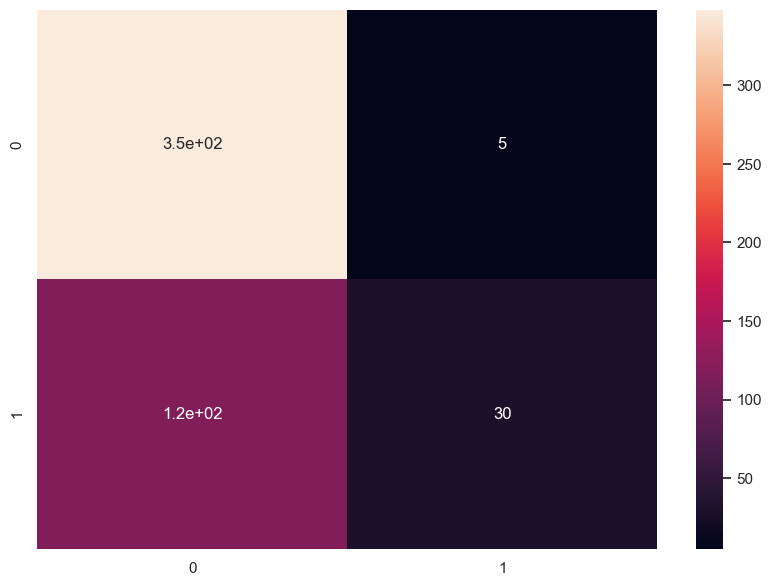

In [55]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.heatmap(pd.DataFrame(cf_mx_cb), annot=True)

cf_mx_lr = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(pd.DataFrame(cf_mx_lr), annot=True)

In [119]:
thresholds = np.linspace(0, 1, 50)

In [124]:
def thresholding(X, y, threshold, model=CatBoostClassifier()):
    model.set_probability_threshold(i)
    y_pred_t = model.predict(X_test)
    return {'Threshold': threshold, 
            'Precision': precision_score(y, y_pred_t), 
            'Recall': recall_score(y, y_pred_t), 
            'F1': f1_score(y, y_pred_t)}

In [125]:
a=[]
for i in thresholds:
    a.append(thresholding(X_test, y_test, i, cb_best.best_estimator_))

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

In [136]:
pd.DataFrame(a).sort_values(['F1','Precision'], ascending=[False, False])

,Threshold,Precision,Recall,F1
14,0.285714,0.403704,0.741497,0.522782
15,0.306122,0.458763,0.605442,0.521994
16,0.326531,0.513889,0.503401,0.508591
13,0.265306,0.360000,0.857143,0.507042
17,0.346939,0.575472,0.414966,0.482213
12,0.244898,0.316629,0.945578,0.474403
18,0.367347,0.623529,0.360544,0.456897
0,0.000000,0.294000,1.000000,0.454405
1,0.020408,0.294000,1.000000,0.454405
2,0.040816,0.294000,1.000000,0.454405


In [56]:
cb_best.best_estimator_.set_probability_threshold(0.428571)

In [70]:
y_pred = cb_best.best_estimator_.predict(X_test)

In [71]:
cf_mx = confusion_matrix(y_test, y_pred)

<Axes: >

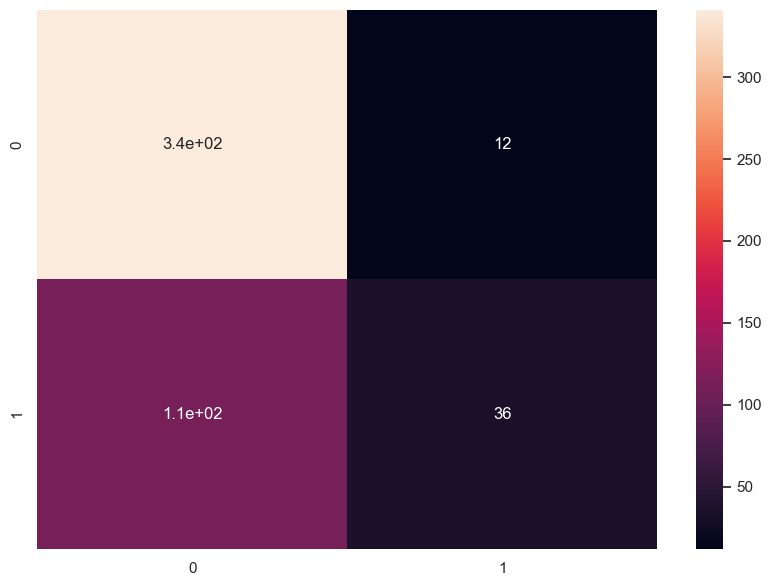

In [72]:
sns.heatmap(pd.DataFrame(cf_mx), annot=True)

In [73]:
print('CatBoost: ', 
      '\n    Precision: ', precision_score(y_test, y_pred), 
      '\n    Recall: ', recall_score(y_test, y_pred),
      '\n    F1: ', f1_score(y_test, y_pred))

CatBoost:  
    Precision:  0.75 
    Recall:  0.24489795918367346 
    F1:  0.3692307692307692


In [88]:
y_pred = [1]*len(y_test)

In [89]:
print('Baseline: ', 
      '\n    Precision: ', precision_score(y_test, y_pred), 
      '\n    Recall: ', recall_score(y_test, y_pred),
      '\n    F1: ', f1_score(y_test, y_pred))

Baseline:  
    Precision:  0.294 
    Recall:  1.0 
    F1:  0.4544049459041731


In [90]:
cf_mx = confusion_matrix(y_test, y_pred)

<Axes: >

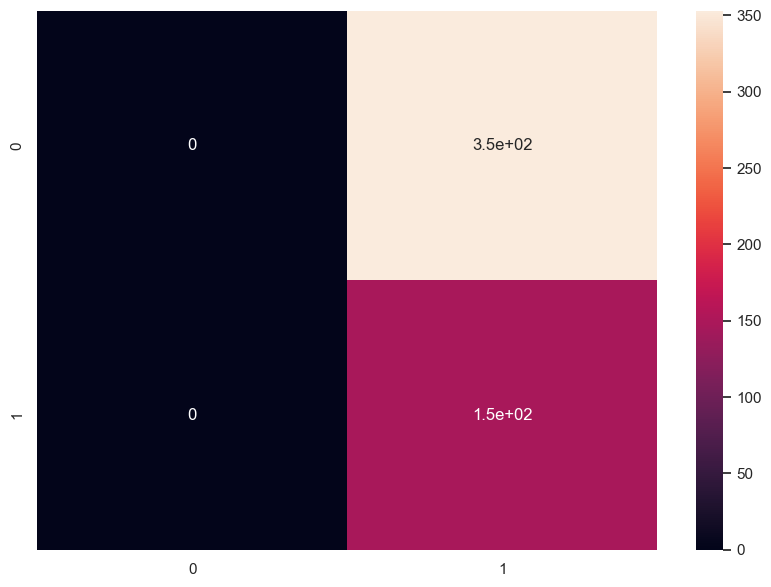

In [91]:
sns.heatmap(pd.DataFrame(cf_mx), annot=True)